## **1. Install the atari gym environment package & Import the library, set the pytorch device**

In [19]:
try:
    if installed:
        print('Installed')
except:
    !pip install -q gym[atari,accept-rom-license] ale-py
    installed = True

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import math
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
from gym.wrappers import AtariPreprocessing, FrameStack
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import display, clear_output
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## **2. Replay buffer function and Plot function**

In [3]:
class Replay_Buffer:
    # 1. where capacity indicates the size of the experience replay pool
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    # 2. Store method Single data <state, action, new_state, reward, done>
    def store(self, state, action, new_state, reward, done):
        state = np.expand_dims(state, 0)
        new_state = np.expand_dims(new_state, 0)

        self.buffer.append([state, action, new_state, reward, done])
    # 3. replay method randomly demands a certain batch of data
    def replay(self, batch_size):
        state, action, new_state, reward, done = zip(
            *random.sample(self.buffer, batch_size)
        )

        return np.concatenate(state), action, np.concatenate(new_state), reward, done

    def __len__(self):
        return len(self.buffer)
    
def plot(i_episode, lis_reward, lis_loss):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (i_episode, np.mean(lis_reward[-10:])))
    plt.plot(lis_reward)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(lis_loss)
    plt.show()

## **3. CNN_Deep_Q_Network Class**

In [4]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()

        self.input_shape = input_shape
        self.num_actions = num_actions

        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

    def forward(self, x):
        x = x.float()
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        return self.features(torch.autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)

    def act(self, state, steps):
        epsilon_S = 1.0
        epsilon_E = 0.01
        epsilon_decay = 30000
        _epsilon = lambda frame: epsilon_E + (epsilon_S - epsilon_E)*np.exp(-frame/epsilon_decay)
        
        epsilon = _epsilon(steps)
        with torch.no_grad():
            if random.random() > epsilon:
                state   = torch.FloatTensor(state).unsqueeze(0)
                state = state.to(device)
                q_value = self.forward(state)
                action  = q_value.max(1)[1].item()
            else:
                action = random.randrange(env.action_space.n)
        return action
    
class D_Q_learning(object):
    def __init__(self):
        self.policy_model = CnnDQN(env.observation_space.shape, env.action_space.n).to(device)
        self.target_model = CnnDQN(env.observation_space.shape, env.action_space.n).to(device)
        self.optimizer = optim.Adam(self.policy_model.parameters(), lr=0.00001)
        self.loss_func = nn.MSELoss()

    def train(self,replay_buffer,batch_size,steps):
        # Attempt to update target_model at 100 per step, using parameters from policy_model
        if steps % 100 == 0:
            self.target_model.load_state_dict(self.policy_model.state_dict())

        # First sample from the experience replay pool and process the data
        state, action, reward, next_state, done = replay_buffer.replay(batch_size)
        # Float the data to ensure that it can be passed to the pytorch neural network for processi
        state      = torch.tensor(state).to(device)
        next_state = torch.tensor(np.array(next_state), requires_grad=False).to(device)
        action     = torch.LongTensor(action).to(device)
        reward     = torch.FloatTensor(reward).to(device)
        done       = torch.FloatTensor(done).to(device)

        # Gradient update training for Policy Q model
        policy_q_values = self.policy_model(state).gather(1, action.unsqueeze(1)).squeeze(1)
        # Get the Q value of the action that maximizes the value of the current state as y expected_q_values
        target_q_values = self.target_model(next_state).max(1)[0].detach()
        expected_q_value = reward + gamma * target_q_values * (1 - done)

        loss = self.loss_func(policy_q_values,expected_q_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss

## **4. Initialize the environment and define hyperparameters**

In [48]:
env_id = "PongNoFrameskip-v4" 
# env_id ="AssaultNoFrameskip-v4"
env = AtariPreprocessing(gym.make(env_id),grayscale_obs=True,
                         scale_obs=False,
                         terminal_on_life_loss=True)
env = FrameStack(env, num_stack=4)

try:
    DQN = torch.load(env_id + '_CNN_DQN.pth', map_location=device)
    lis_reward = pd.read_csv(env_id + "_CNN_lis_reward.csv", header=None)[0].tolist()
    lis_loss = pd.read_csv(env_id + "_CNN_lis_loss.csv", header=None)[0].tolist()
except:
    print("New Created")
    DQN = D_Q_learning()
    lis_loss = []
    lis_reward = []

replay_buffer = Replay_Buffer(80000)

batch_size = 32
gamma      = 0.99

episode_reward = 0
steps = 0

## **6. Start training (simulate the flow of DQL algorithm operation)**

In [ ]:
num_episodes = 450

for i_episode in range(num_episodes+1):
    state, _ = env.reset()
    # state = env.reset()
    done = False
    
    while not done:
        action = DQN.policy_model.act(np.array(state),steps)
        next_state, reward, done, _, _ = env.step(action)
        #next_state, reward, done, _ = env.step(action)
        replay_buffer.store(np.array(state), action, reward, np.array(next_state), float(done))
        state = next_state
        episode_reward += reward
        steps += 1
        
        if len(replay_buffer) > 8000:
            loss = DQN.train(replay_buffer, batch_size, steps)
            lis_loss.append(loss.item())
        
        if done:
            lis_reward.append(episode_reward)
            episode_reward = 0
            break
            
    if i_episode % 10 == 0:
        plot(i_episode, lis_reward, lis_loss)

    if i_episode % 50 == 0:
        torch.save(DQN, env_id + '_CNN_DQN.pth')
        pd.DataFrame(lis_reward).to_csv(env_id + "_CNN_lis_reward.csv", header=False, index=False)
        pd.DataFrame(lis_loss).to_csv(env_id + "_CNN_lis_loss.csv", header=False, index=False)

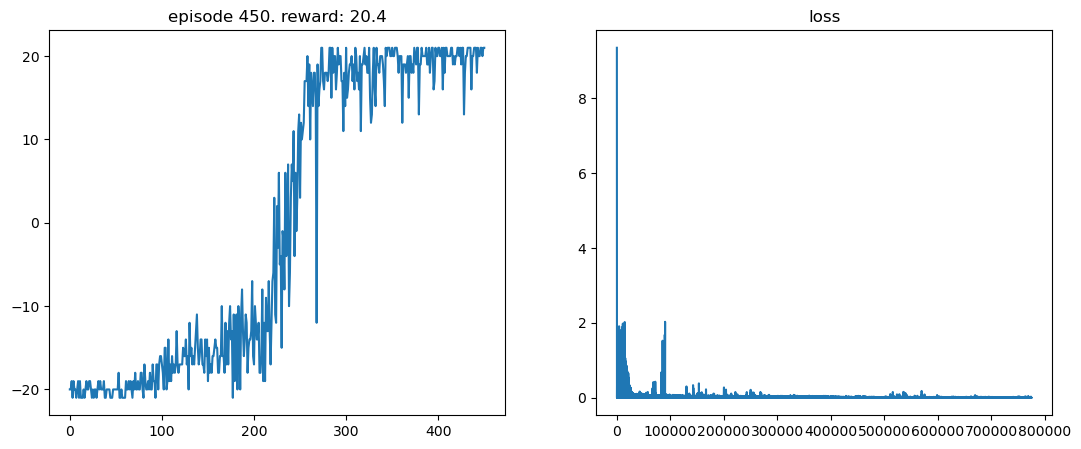

## **7. Test the model**

In [ ]:
env_id = "PongNoFrameskip-v4" 
t_env = AtariPreprocessing(gym.make(env_id,render_mode='rgb_array'),
                           grayscale_obs=True, scale_obs=False,terminal_on_life_loss=False)
t_env = FrameStack(t_env, num_stack=4)

# load the uploaded data model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
DQN_test = torch.load("/kaggle/input/dqnmodel/PongNoFrameskip-v4_CNN_DQN.pth", map_location='cpu')

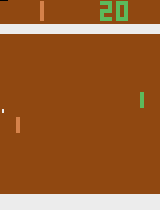

In [114]:
state, _ = t_env.reset()
done = False
while not done:
    img = t_env.render()
    image = Image.fromarray(img)
    clear_output(wait=True)
    display(image)
    time.sleep(0.03)
    
    action = DQN.policy_model.act(np.array(state),1e6)
    next_state, _, done, _,_ = t_env.step(action)
    state = next_state